ver: 20201205.1341

In [1]:
# Initialization for this notebook.

import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt

# Common sequence generators.
seq_delta = lambda n_min, n_max: (np.array([ 1 if n==0 else 0 for n in range(n_min, n_max+1)]), 0 - n_min)
seq_u = lambda n_min, n_max: (np.array([ 0 if n<0 else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_R_N = lambda N, n_min, n_max: (np.array([ 0 if (n<0 or n>=N) else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_real_exp = lambda a, n_min, n_max: (np.array([ 0 if n<0 else a**n for n in range(n_min, n_max+1)]), 0-n_min)
seq_complex_exp = lambda sigma, omega_0, n_min, n_max: (np.array([ np.exp((sigma + 1j*omega_0)*n) for n in range(n_min, n_max+1)]), 0-n_min)
seq_sin = lambda A, omega_0, phi, n_min, n_max: (np.array([ A*np.sin(omega_0*n + phi) for n in range(n_min, n_max+1)]), 0-n_min)

# Un-comment the following line to use interactive matplotlib widget.
# %matplotlib widget

In [2]:
def analyze_lpf(w_p, w_st, b, a=1, show_plot=False, samples_per_band=128):
    """Find the R_p and A_s of the given LPF and optionally show the frequency response plots.
    
    Parameters:
      w_p : float
        Pass band edge frequency, in rad.
      w_st : float
        Stop band edge frequency, in rad.
      b : array_like
        Numerator of the transfer function.
      a : array_like, optional
        Denominator of the transfer function. Default is 1 (FIR filter).
      show_plot : bool, optional
        Set to True to show the frequency response plots. Default is False.
      samples_per_band : int, optional
        Number of frequency samples per band (pass, transition and stop). Generally, more samples will give more accurate results. Default is 128.
    
    Returns:
      R_p: float
        Pass band ripple, in dB.
      A_s: float
        Stop band attenuation, in dB.
    """

    # [BEST PRACTICE] Do not add redundant comments if the code is self-explanatory enough.
    dB = lambda x: 20 * np.log10(x)

    # Compute frequency respone samples for each band.
    w = []      # To store frequency samples for each band.
    H = []      # To store frequency respone samples for each band.
    H_abs = []  # To store the absolute values for H.
    for (w_start, w_end) in [(0, w_p), (w_p, w_st), (w_st, np.pi)]:
        w_tmp, H_tmp = signal.freqz(b=b, a=a, worN=np.linspace(w_start, w_end, samples_per_band))
        w.append(w_tmp)
        H.append(H_tmp)
        H_abs.append(np.abs(H_tmp))

    # [BEST PRACTICE] Use contants for more readable code.
    NUM_BANDS = 3
    [PASS_BAND, TRAN_BAND, STOP_BAND] = range(NUM_BANDS)

    R_p = -dB(np.min(H_abs[PASS_BAND]))
    A_s = -dB(np.max(H_abs[STOP_BAND]))

    if show_plot:
        NUM_PLOTS = 2
        [AMP_PLOT, PHASE_PLOT] = range(NUM_PLOTS)

        fig, axs = plt.subplots(NUM_PLOTS, 1 ,sharex='col')

        # Plot the frequency response.
        for band in range(NUM_BANDS):
            axs[AMP_PLOT].plot(w[band], dB(H_abs[band]))
            axs[PHASE_PLOT].plot(w[band], np.angle(H[band]))
        axs[AMP_PLOT].legend(['pass', 'transition', 'stop'])
        axs[PHASE_PLOT].set_xlim(left=0, right=np.pi)
        axs[AMP_PLOT].set_ylabel('$|H(e^{j \omega})|$ (dB)')
        axs[PHASE_PLOT].set_ylabel('arg$[H(e^{j \omega})]$')
        axs[PHASE_PLOT].set_xlabel('$\omega$')
        axs[AMP_PLOT].grid()
        axs[PHASE_PLOT].grid()

        # Show ticks as multiple of pi.
        def tick_format_pi(value, tick_number):
            return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'
        axs[PHASE_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
        axs[PHASE_PLOT].xaxis.set_major_locator(plt.MultipleLocator(np.pi/4))
        axs[PHASE_PLOT].yaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
        axs[PHASE_PLOT].yaxis.set_major_locator(plt.MultipleLocator(np.pi/2))

        # Add horizontal lines to indicate R_p and A_s.
        axs[AMP_PLOT].axhline(y=-R_p, linestyle='--', color='orange')
        axs[AMP_PLOT].axhline(y=-A_s, linestyle='--', color='green')
        # Use axis on the right hand side to show the labels.
        axs[AMP_PLOT].secondary_yaxis('right').set_yticks([-R_p, -A_s])

        # Add vertical lines to indicate w_p and w_st.
        for plot in range(NUM_PLOTS):
            axs[plot].axvline(x=w_p, linestyle='--', color='orange')
            axs[plot].axvline(x=w_st, linestyle='--', color='green')
        ax_phase_top = axs[PHASE_PLOT].secondary_xaxis('top')
        ax_phase_top.xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
        ax_phase_top.set_xticks([w_p, w_st])

    return R_p, A_s

In [3]:
def test_filter(b, a, x):
    """Test a filter by comparing the input and output.

    Parameters:
      b : array_like
        Numerator of the transfer function.
      a : array_like
        Denominator of the transfer function.
      x : array_like
        Input sequence.
    
    Returns:
      y : array_like
        Output sequence.
    """
    y = signal.lfilter(b=b, a=a, x=x)

    X = fft.fft(x)
    Y = fft.fft(y)

    def tick_format_pi(value, tick_number):
        return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

    NUM_PLOTS = 2
    [TIME_PLOT, FREQ_PLOT] = range(NUM_PLOTS)
    fig, axs = plt.subplots(NUM_PLOTS,1)

    N = len(x)
    n = np.arange(N)
    axs[TIME_PLOT].plot(n, x, linewidth=3, color='red', alpha=0.5)
    axs[TIME_PLOT].plot(n, y, linewidth=2, color='green');
    axs[TIME_PLOT].legend(['x', 'y'])
    axs[TIME_PLOT].set_xlabel('n')

    w = n*2*np.pi/N
    axs[FREQ_PLOT].plot(w, abs(X), color='red', alpha=0.5)
    axs[FREQ_PLOT].plot(w, abs(Y), color='green')
    axs[FREQ_PLOT].legend(['|X|', '|Y|'])
    axs[FREQ_PLOT].set_xlabel('$\omega$')
    axs[FREQ_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
    axs[FREQ_PLOT].xaxis.set_major_locator(plt.MultipleLocator(np.pi/4))

    return y

【例7.2】 用窗函数法设计一个$h(n)$偶对称的线性相位 FIR 低通滤波器，给定通带截止频率 $\omega_p=0.3\pi$，阻带截止频率为 $\omega_{st}=0.5\pi$，阻带衰减为 $A_s=40\text{dB}$。

解：

根据要求的阻带衰减，查课本表7.3可得汉宁窗(`hann`)是符合要求的窗函数中，过渡带最窄的($6.2\pi/N$)。因此滤波器设计代码做如下设置：

```python
window = 'hann'
w_tran = 6.2 * np.pi
```

N = 31, R_p = 0.101173, A_s = 39.076724


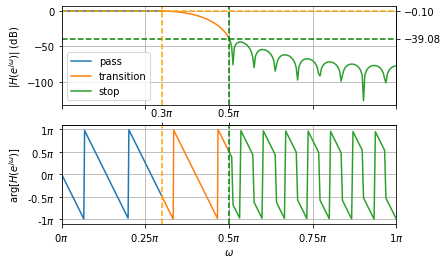

In [4]:
# Target band edge frequencies.
w_p = 0.3 * np.pi
w_st = 0.5 * np.pi

# Based on the target A_s, choose a window.
window = 'hann'
w_tran = 6.2 * np.pi

# Compute window length. 
N = int(np.ceil(w_tran / (w_st - w_p)))

# Compute the FIR coefficeints.
w_c = (w_p + w_st) / 2
b = signal.firwin(N, w_c, window=window, fs=2*np.pi)
a = 1

# Analyze the filter.
R_p, A_s = analyze_lpf(w_p, w_st, b=b, a=a, show_plot=True)
print('N = %d, R_p = %f, A_s = %f' % (N, R_p, A_s))

这个滤波器的阻带衰减为39dB，不满足40dB的要求。仔细观察可以发现，导致衰减不够的原因不是最大旁瓣，而是截止频率$\omega_{st}=0.5\pi$所对应的衰减不够大。因此我们不改变窗口，而是通过加大$N$来让过渡带更陡峭些，尝试改善这一点。

N = 32, R_p = 0.066308, A_s = 42.843523


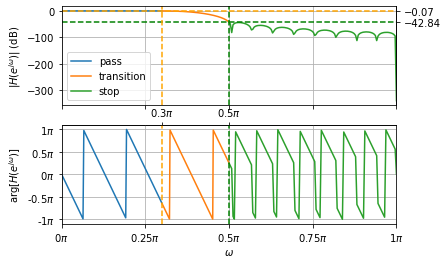

In [5]:
# Compute window length. 
N = int(np.ceil(w_tran / (w_st - w_p))) + 1

# Compute the FIR coefficeints.
w_c = (w_p + w_st) / 2
b = signal.firwin(N, w_c, window=window, fs=2*np.pi)
a = 1

# Analyze the filter.
R_p, A_s = analyze_lpf(w_p, w_st, b=b, a=a, show_plot=True)
print('N = %d, R_p = %f, A_s = %f' % (N, R_p, A_s))

可以看到，加大N之后，就满足要求了。

【问题】
- 为什么这时滤波器的幅频响应，好像比之前 $N=31$ 时“扁”了很多？
- 为什么我们没有讨论 $h(n)$ 是不是“偶”对称？

因此最终的滤波器系数为：

b = [ 0.00000000e+00 -1.32015929e-04 -9.08322937e-04  1.39686361e-18
  4.09233928e-03  4.19507801e-03 -6.42483179e-03 -1.51054190e-02
  8.18813753e-18  2.91129490e-02  2.44902890e-02 -3.35008885e-02
 -7.60327961e-02  1.46075477e-17  1.97118389e-01  3.73095230e-01
  3.73095230e-01  1.97118389e-01  1.46075477e-17 -7.60327961e-02
 -3.35008885e-02  2.44902890e-02  2.91129490e-02  8.18813753e-18
 -1.51054190e-02 -6.42483179e-03  4.19507801e-03  4.09233928e-03
  1.39686361e-18 -9.08322937e-04 -1.32015929e-04  0.00000000e+00]
a = 1


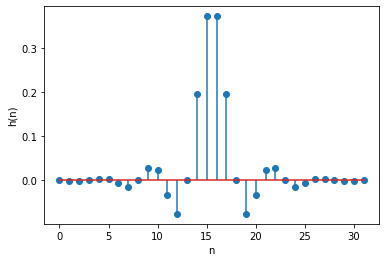

In [6]:
print('b =', b)
print('a =', a)

fig, ax = plt.subplots()
ax.stem(b)
ax.set_xlabel('n')
ax.set_ylabel('h(n)');

我们生成一个包含多个频率成分的信号，观察通过上面设计的滤波器前后的信号变化。

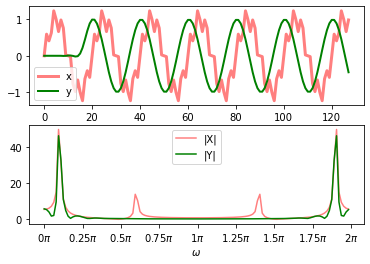

In [7]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1, 0.1*np.pi, 0))    # in the pass band
    x_comp.append((0.3, 0.6*np.pi, 0))  # in the stop band
    
    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max) for A, w, phi in x_comp], axis=0)[0]

    return x

x = gen_signal()
test_filter(b, a, x);

# 【可选】

- 用凯泽窗口(Kaiser)设计一个满足相同技术指标的FIR滤波器
  - 不查表，使用 scipy.signal 中的函数来完成
- 对比分别用凯泽窗口和汉宁窗口设计所得的FIR滤波器的性能（单位冲击响应的长度、时延）